Đang tải tập dữ liệu từ 'C:\DATA\data_4.2.csv'...
Đã tải dữ liệu thành công. Bắt đầu tạo biểu đồ.


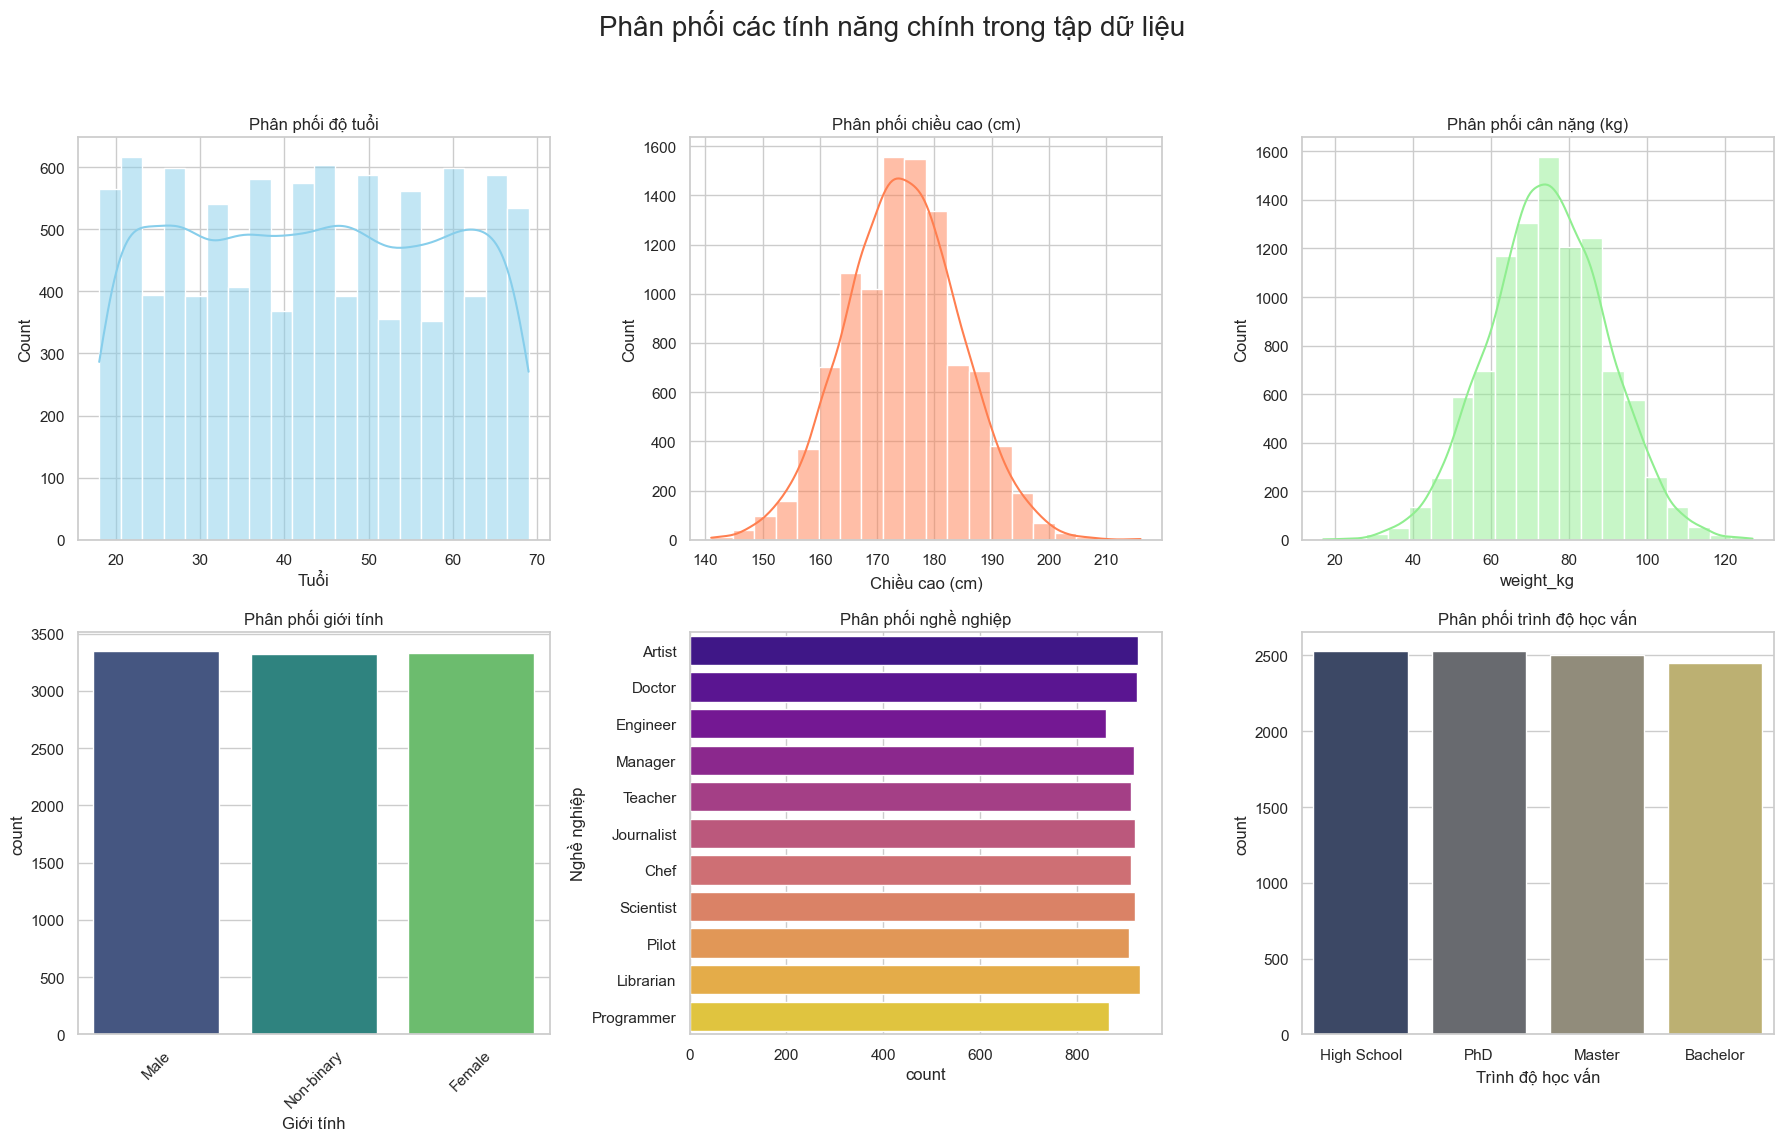


Bắt đầu phân tích và dự đoán BMI bằng Machine Learning

Phân phối các loại BMI:
bmi_class
Normal         3930
Overweight     2855
Obese          1845
Underweight    1370
Name: count, dtype: int64

Kết quả đánh giá tất cả các mô hình:
  - Logistic Regression: Độ chính xác = 0.9735
  - Decision Tree: Độ chính xác = 0.9820
  - Random Forest: Độ chính xác = 0.9320
  - SVC: Độ chính xác = 0.9515
  - K-Nearest Neighbors: Độ chính xác = 0.6965
  - DNN: Độ chính xác = 0.9645
  - CNN: Độ chính xác = 0.9310
  - LSTM: Độ chính xác = 0.9765

Đã lưu mô hình tốt nhất (Decision Tree), bộ tiền xử lý và bộ mã hóa nhãn.


C:\Users\nvqua\AppData\Local\Temp\ipykernel_17060\3841371179.py:236: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df.sort_values(by='Accuracy', ascending=False), palette='viridis')


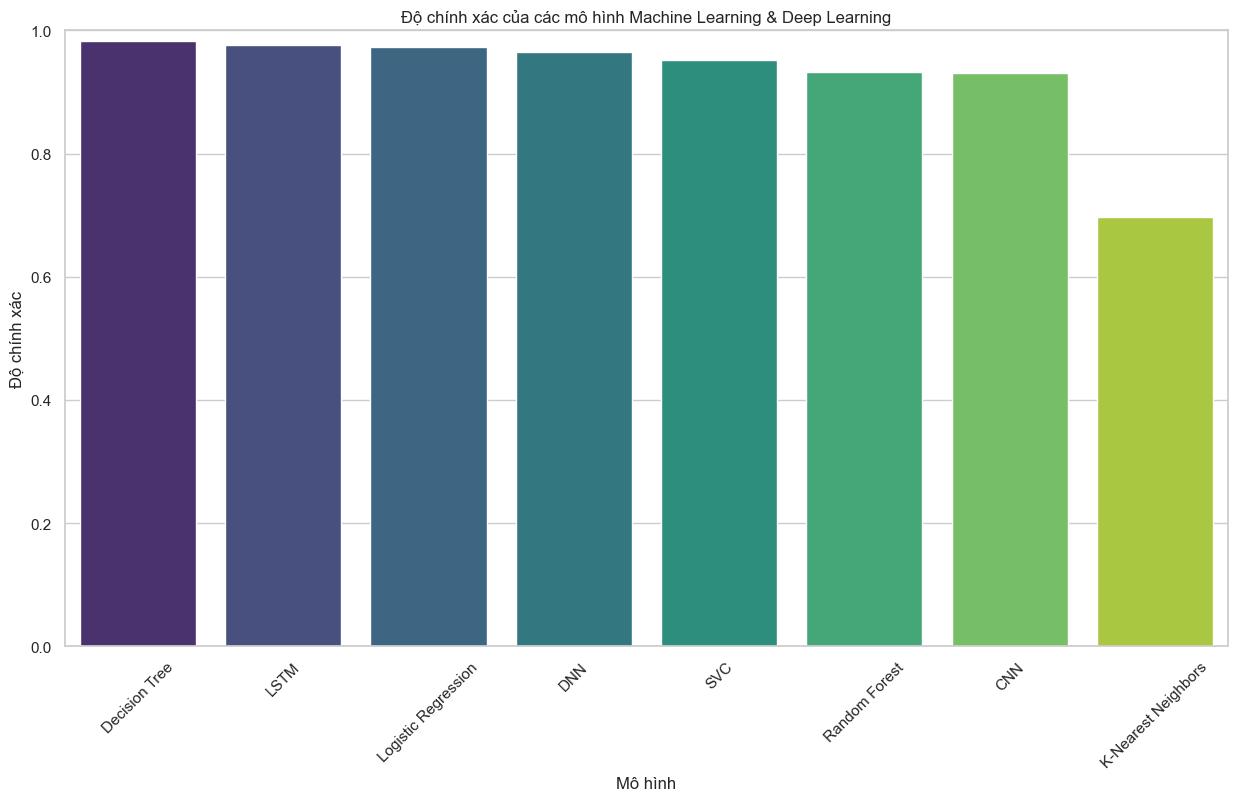


Hoàn thành đánh giá mô hình.
Mô hình tốt nhất là: Decision Tree với độ chính xác 0.9820


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import joblib

# Thêm TensorFlow để xây dựng mô hình học sâu
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, Input

# --- Cấu hình ---
# Đảm bảo đường dẫn tệp này khớp với tệp được tạo trước đó
INPUT_FILE = r'C:\DATA\data_4.2.csv'

# Kiểm tra xem tệp có tồn tại không trước khi tải
if not os.path.exists(INPUT_FILE):
    print(f"Lỗi: Không tìm thấy tệp '{INPUT_FILE}'.")
    print("Vui lòng đảm bảo bạn đã chạy tệp tạo dữ liệu trước đó.")
else:
    # --- Tải dữ liệu ---
    print(f"Đang tải tập dữ liệu từ '{INPUT_FILE}'...")
    df = pd.read_csv(INPUT_FILE)
    print("Đã tải dữ liệu thành công. Bắt đầu tạo biểu đồ.")

    # --- Hiển thị dữ liệu bằng Seaborn ---
    sns.set_theme(style="whitegrid")

    # Tạo một hình với các ô con
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Phân phối các tính năng chính trong tập dữ liệu', fontsize=20)

    # Vẽ biểu đồ phân phối cho các tính năng số
    sns.histplot(df['age'], bins=20, kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Phân phối độ tuổi')
    axes[0, 0].set_xlabel('Tuổi')

    sns.histplot(df['height_cm'], bins=20, kde=True, ax=axes[0, 1], color='coral')
    axes[0, 1].set_title('Phân phối chiều cao (cm)')
    axes[0, 1].set_xlabel('Chiều cao (cm)')

    sns.histplot(df['weight_kg'], bins=20, kde=True, ax=axes[0, 2], color='lightgreen')
    axes[0, 2].set_title('Phân phối cân nặng (kg)')

    # Vẽ biểu đồ phân phối cho các tính năng phân loại
    sns.countplot(x='gender', data=df, ax=axes[1, 0], palette='viridis', hue='gender', legend=False)
    axes[1, 0].set_title('Phân phối giới tính')
    axes[1, 0].set_xlabel('Giới tính')
    axes[1, 0].tick_params(axis='x', rotation=45)

    sns.countplot(y='job', data=df, ax=axes[1, 1], palette='plasma', hue='job', legend=False)
    axes[1, 1].set_title('Phân phối nghề nghiệp')
    axes[1, 1].set_ylabel('Nghề nghiệp')

    sns.countplot(x='education_level', data=df, ax=axes[1, 2], palette='cividis', hue='education_level', legend=False)
    axes[1, 2].set_title('Phân phối trình độ học vấn')
    axes[1, 2].set_xlabel('Trình độ học vấn')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Bắt đầu phần Machine Learning ---
    print("\n" + "="*50)
    print("Bắt đầu phân tích và dự đoán BMI bằng Machine Learning")
    print("="*50)

    # 1. Tính toán BMI
    df['height_m'] = df['height_cm'] / 100
    df['bmi'] = df['weight_kg'] / (df['height_m']**2)

    # 2. Phân loại BMI
    def classify_bmi(bmi):
        if bmi < 18.5:
            return 'Underweight'
        elif 18.5 <= bmi < 24.9:
            return 'Normal'
        elif 25 <= bmi < 29.9:
            return 'Overweight'
        else:
            return 'Obese'

    df['bmi_class'] = df['bmi'].apply(classify_bmi)

    # In ra số lượng của mỗi loại BMI
    print("\nPhân phối các loại BMI:")
    print(df['bmi_class'].value_counts())

    # 3. Chuẩn bị dữ liệu cho tất cả các mô hình
    features = ['age', 'height_cm', 'weight_kg', 'years_experience', 'salary', 'gender', 'job', 'education_level']
    target = 'bmi_class'
    
    X = df[features]
    y = df[target]

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Chuẩn bị dữ liệu cho tất cả các mô hình (kể cả học sâu)
    categorical_features = ['gender', 'job', 'education_level']
    numerical_features = ['age', 'height_cm', 'weight_kg', 'years_experience', 'salary']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'
    )

    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Mã hóa nhãn (target) cho các mô hình học sâu
    label_encoder = OneHotEncoder(sparse_output=False)
    y_train_encoded = label_encoder.fit_transform(y_train.values.reshape(-1, 1))
    y_test_encoded = label_encoder.transform(y_test.values.reshape(-1, 1))

    # --- Huấn luyện và đánh giá tất cả các mô hình ---
    print("\nKết quả đánh giá tất cả các mô hình:")
    
    # Định nghĩa các mô hình
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(),
        "SVC": SVC(),
        "K-Nearest Neighbors": KNeighborsClassifier()
    }

    # Định nghĩa mô hình học sâu và thêm vào danh sách
    num_classes = len(df['bmi_class'].unique())
    input_shape = X_train_processed.shape[1]

    # Mô hình Mạng nơ-ron truyền thẳng (DNN)
    dnn_model = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    models["DNN"] = dnn_model

    # Mô hình Mạng nơ-ron tích chập 1D (CNN)
    cnn_model = Sequential([
        Input(shape=(input_shape, 1)),
        Conv1D(filters=64, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    models["CNN"] = cnn_model
    
    # Mô hình Mạng nơ-ron hồi quy (LSTM)
    lstm_model = Sequential([
        Input(shape=(1, input_shape)),
        LSTM(64),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    models["LSTM"] = lstm_model

    best_model_name = ""
    best_accuracy = 0
    results = []

    for name, model in models.items():
        if isinstance(model, Sequential):  # Kiểm tra mô hình học sâu
            if name == "CNN":
                X_train_dl = X_train_processed.reshape(X_train_processed.shape[0], X_train_processed.shape[1], 1)
                X_test_dl = X_test_processed.reshape(X_test_processed.shape[0], X_test_processed.shape[1], 1)
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                model.fit(X_train_dl, y_train_encoded, epochs=10, batch_size=32, verbose=0)
                loss, accuracy = model.evaluate(X_test_dl, y_test_encoded, verbose=0)
            elif name == "LSTM":
                X_train_dl = X_train_processed.reshape(X_train_processed.shape[0], 1, X_train_processed.shape[1])
                X_test_dl = X_test_processed.reshape(X_test_processed.shape[0], 1, X_test_processed.shape[1])
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                model.fit(X_train_dl, y_train_encoded, epochs=10, batch_size=32, verbose=0)
                loss, accuracy = model.evaluate(X_test_dl, y_test_encoded, verbose=0)
            else: # DNN
                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
                model.fit(X_train_processed, y_train_encoded, epochs=10, batch_size=32, verbose=0)
                loss, accuracy = model.evaluate(X_test_processed, y_test_encoded, verbose=0)
        else:  # Các mô hình truyền thống
            model.fit(X_train_processed, y_train)
            y_pred = model.predict(X_test_processed)
            accuracy = accuracy_score(y_test, y_pred)
            
        results.append({
            'Model': name, 
            'Accuracy': accuracy, 
        })
        print(f"  - {name}: Độ chính xác = {accuracy:.4f}")
        
        # Chọn mô hình tốt nhất
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = name

    # --- Lưu mô hình tốt nhất và các thành phần tiền xử lý ---
    try:
        # Nếu mô hình tốt nhất là học sâu (Keras), lưu bằng save()
        if isinstance(models[best_model_name], Sequential):
            models[best_model_name].save('best_model.keras')
        # Nếu là mô hình scikit-learn, lưu bằng joblib
        else:
            joblib.dump(models[best_model_name], 'best_model.joblib')
        
        # Luôn lưu preprocessor và label_encoder
        joblib.dump(preprocessor, 'preprocessor.joblib')
        joblib.dump(label_encoder, 'label_encoder.joblib')
        
        print(f"\nĐã lưu mô hình tốt nhất ({best_model_name}), bộ tiền xử lý và bộ mã hóa nhãn.")
    except Exception as e:
        print(f"\nLỗi khi lưu mô hình: {e}")

    # --- Trực quan hóa kết quả ---
    results_df = pd.DataFrame(results)
    
    plt.figure(figsize=(15, 8))
    sns.barplot(x='Model', y='Accuracy', data=results_df.sort_values(by='Accuracy', ascending=False), palette='viridis')
    plt.title('Độ chính xác của các mô hình Machine Learning & Deep Learning')
    plt.ylim(0, 1)
    plt.ylabel('Độ chính xác')
    plt.xlabel('Mô hình')
    plt.xticks(rotation=45)
    plt.show()

    print("\n" + "="*50)
    print("Hoàn thành đánh giá mô hình.")
    print("="*50)
    print(f"Mô hình tốt nhất là: {best_model_name} với độ chính xác {best_accuracy:.4f}")
